In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn
import os
import tqdm
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

resnet50 = []
resnet50 = models.resnet50(pretrained=True,progress=False)
resnet50_not_pretrained = []
resnet50_not_pretrained = models.resnet50(pretrained=False, progress=False)

#vgg16 = models.vgg16(pretrained=False, progress=True)
#resnet18 = models.resnet18(pretrained=True, progress=True)

In [0]:
! ls /content/drive

ls: cannot access '/content/drive': No such file or directory


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
#net =     nn.ModuleList([resnet50, nn.Linear(1000,10)])
#net =  nn.ModuleList([vgg16, nn.Linear(1000,10)])

net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

# the_model.load_state_dict(torch.load(PATH))

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Functions

In [0]:
# data loader with data augmentation transform
class Data_to_load(torch.utils.data.Dataset):
    def __init__(self, input, labels, transform=None):
        
        if transform is not None:
            input = [transform(image) for image in input]
            
        self.input = input
        self.labels = labels
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, ind):
        return [self.input[ind], self.labels[ind]]

In [0]:
def run(net, train_loader, 
        path_save_dict='./drive/My Drive/Project_DL/checkpoint_renet_50_robust.pth',
        n_epoch=50, lr=0.1, momentum=0.9, scheduled=False):
  
  device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
  net.to(device)

  if len(net) == 2:
    # if resnet
    criterion = nn.CrossEntropyLoss() 
  else:
    # if vgg 
    criterion = nn.NLLLoss()
    
  # optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5*1e-4)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, 
                              momentum=momentum, weight_decay=5*1e-4)
  if scheduled:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                step_size=15, gamma=0.1)

  test_accuracy = []
  train_accuracy = []

  loss_train = []
  best_accuracy = 10
  for epoch in tqdm.notebook.tqdm(range(n_epoch)):  # loop over the dataset multiple times

      correct = 0
      total = 0
      net.train()
      running_loss = []
      for i, data in enumerate(train_loader):
          
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs_gpu = inputs.to(device)
          labels_gpu = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize

          # comment if using our net
          if len(net) == 2:
            outputs = net[1](net[0](inputs_gpu))
          else:
          # comment if using resnet
            outputs = net(inputs_gpu)

          loss = criterion(outputs, labels_gpu)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss.append(loss.item())

          # evaluate train accuracy
          with torch.no_grad():
            #_, predicted = torch.max(nn.Softmax()(outputs).data, 1)

            predicted = nn.functional.softmax(outputs, dim=1).detach().argmax(dim=1)
            total += labels_gpu.size(0)
            correct += (predicted == labels_gpu).sum().item()

      loss_train.append(np.mean(running_loss))
      train_accuracy.append(100 * correct / total)

      # evaluate on test dataloader
      correct = 0
      total = 0
      net.eval()
      with torch.no_grad():
          for data in testloader:
              images, labels = data
              images = images.to(device)
              labels = labels.to(device)

              # comment if using our net
              if len(net) == 2:
                outputs = net[1](net[0](images))
              else:
                # comment if using resnet
                outputs = net(images)
              
              #_, predicted = torch.max(nn.Softmax()(outputs).data, 1)
              predicted = nn.functional.softmax(outputs, dim=1).detach().argmax(dim=1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      test_accuracy.append(100 * correct / total)
      
      if len(train_accuracy) > 2 and train_accuracy[-1] > best_accuracy:
        torch.save(net.state_dict(), path_save_dict)
        best_accuracy = test_accuracy[-1] 

      display.clear_output(True)
      plt.figure(figsize=(16, 8))
      plt.subplot(121)
      plt.plot(loss_train, label='train loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss') 

      plt.subplot(122)
      plt.plot(train_accuracy, label='train accuracy')   
      plt.plot(test_accuracy, label='test accuracy')
      plt.xlabel('Iterations')
      plt.ylabel('Accuracy')

      plt.show() 
      print('#Epoch: %d | Loss Train: %.3f | Acc train: %.3f | Acc: %.3f' % 
            (epoch, loss_train[-1], train_accuracy[-1], test_accuracy[-1]))
      
      if scheduled:
        # Decay Learning Rate
        scheduler.step()
      
  print('Finished Training')
  return net, test_accuracy, loss_train, train_accuracy

In [0]:
def model_eval(net, testloader):

    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    net.to(device)

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            if len(net) == 2:
              outputs = net[1](net[0](images))
            else:
              outputs = net(images)
            
            # _, predicted = torch.max(nn.Softmax()(outputs).data, 1)
            predicted = nn.functional.softmax(outputs, dim=1).detach().argmax(dim=1)
            #predicted = outputs.detach().argmax(dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [0]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        Flatten(),
        nn.Linear(256 * (32 // 16) ** 2, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 10),
        nn.LogSoftmax(dim=1)
    )
    return model


In [0]:
# a special module reshapes tensor from [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

## Data Loading

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img # / 2 + 0.5     # unnormalize
    #npimg = train_data_non_robust[0].numpy()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Their robust dataset:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


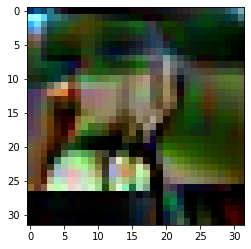

deer


In [0]:
# load robust dataset from the paper
data_path = "./drive/My Drive/Project_DL/d_robust_CIFAR"

train_data_robust = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_ims")))
train_labels_robust = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_lab")))
train_set_robust = Data_to_load(train_data_robust, train_labels_robust)
train_loader_robust = torch.utils.data.DataLoader(train_set_robust, batch_size=128, shuffle=True)

print("Their robust dataset:")
imshow(torch.tensor(train_set_robust[55][0]).detach().cpu())
print(classes[train_set_robust[55][1]])

Their non-robust dataset:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


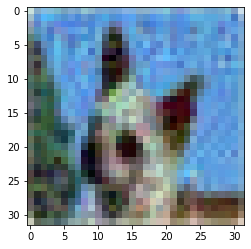

frog


In [0]:
# load non-robust datasets from the paper
data_path = "./drive/My Drive/Project_DL/d_non_robust_CIFAR"

train_data_non_robust = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_ims")))
train_labels_non_robust = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_lab")))
train_set_non_robust = torch.utils.data.TensorDataset(train_data_non_robust, train_labels_non_robust) 

train_loader_non_robust = torch.utils.data.DataLoader(train_set_non_robust, batch_size=128,
                                          shuffle=True)

print("Their non-robust dataset:")
imshow(torch.tensor(train_set_non_robust[30][0]).detach().cpu())
print(classes[train_set_non_robust[30][1]])

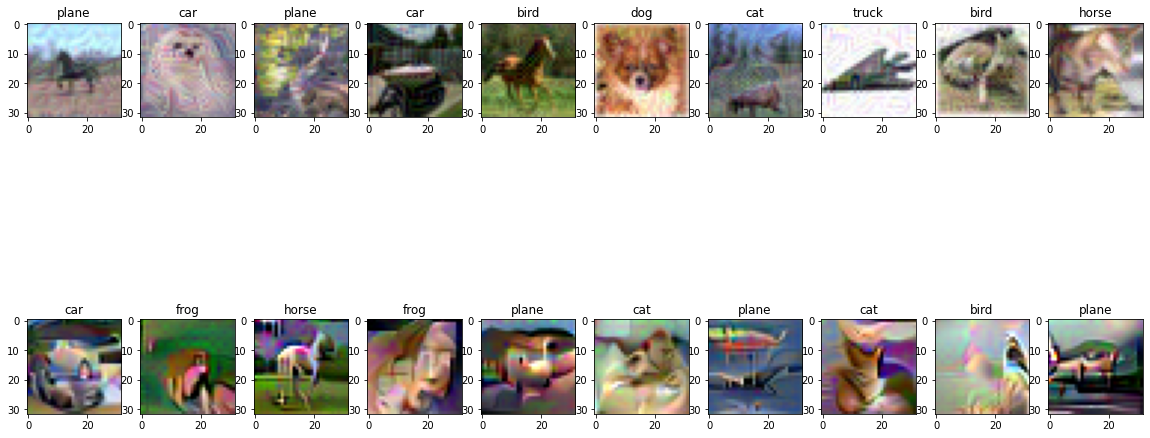

In [0]:
# random pics from non-robust and robust from the paper
n_pics_to_show = 10
fig, ax = plt.subplots(2, n_pics_to_show, figsize=(20, 10))

for i in range(n_pics_to_show):
    rand_idx = np.random.randint(len(train_set_robust))
    #rand_idx = i
    pic = train_data_non_robust[rand_idx]
    label = int(train_labels_non_robust[rand_idx])
    pic2, label2 = train_set_robust[rand_idx]

    pic_np = pic.cpu().data.numpy()
    pic_np = np.rollaxis(pic_np, 0, 3)    # 3xHxW to HxWx3

    pic_np2 = pic2.cpu().data.numpy()
    pic_np2 = np.rollaxis(pic_np2, 0, 3)    # 3xHxW to HxWx3

    ax[0, i].imshow(pic_np)
    ax[0, i].set_title(classes[label])

    ax[1, i].imshow(pic_np2)
    ax[1, i].set_title(classes[label2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Our ddet dataset:


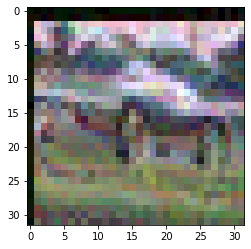

car


In [97]:
# load our non-robust dataset 
ours_non_robust_test = torch.load('/content/drive/My Drive/Project_DL/ours_non_robust.pt')
values = [torch.tensor(image[0]).float().reshape(3, 32, 32) for image in ours_non_robust_test]
labels = [image[2].item() for image in ours_non_robust_test]

ours_set_non_robust_test = Data_to_load(values, labels)
ours_loader_non_robust_test = torch.utils.data.DataLoader(ours_set_non_robust_test, batch_size=128, shuffle=False)

# printing images from datasets
print("Our ddet dataset:")
imshow(torch.tensor(ours_set_non_robust_test[7][0]).detach().cpu())
print(classes[ours_set_non_robust_test[7][1]])

In [0]:
# for robust use augmentation because the dataset contains only 1101 images
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomRotation(30),
     transforms.ToTensor()])

Our ddet dataset:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


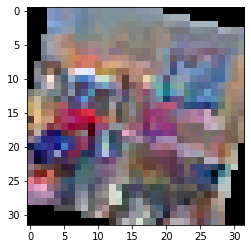

truck


In [103]:
# load our robust dataset 
ours_robust_test = torch.load('/content/drive/My Drive/Project_DL/Rrr_train-2.pt')
values = [torch.tensor(image[0]).float().reshape(3, 32, 32) for image in ours_robust_test]
labels = [image[1] for image in ours_robust_test]

ours_set_robust_test = Data_to_load(values, labels[:len(trainset)], transform)
ours_loader_robust_test = torch.utils.data.DataLoader(ours_set_robust_test, batch_size=128, shuffle=False)

# printing images from datasets
print("Our ddet dataset:")
imshow(torch.tensor(ours_set_robust_test[59][0]).detach().cpu())
print(classes[ours_set_robust_test[59][1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


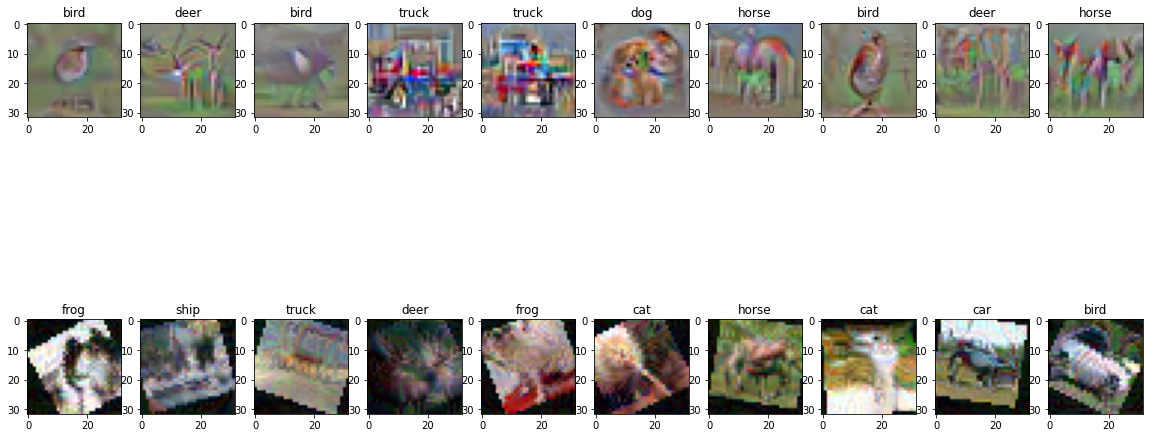

In [79]:
# random pics from non-robust and robust ours
n_pics_to_show = 10
fig, ax = plt.subplots(2, n_pics_to_show, figsize=(20, 10))

for i in range(n_pics_to_show):
    rand_idx = np.random.randint(len(ours_set_robust_test))
    #rand_idx = i
    pic = ours_set_robust_test[rand_idx][0]
    label = int(ours_set_robust_test[rand_idx][1])
    pic2, label2 = ours_set_non_robust_test[rand_idx]

    pic_np = pic.cpu().data.numpy()
    pic_np = np.rollaxis(pic_np, 0, 3)    # 3xHxW to HxWx3

    pic_np2 = pic2.cpu().data.numpy()
    pic_np2 = np.rollaxis(pic_np2, 0, 3)    # 3xHxW to HxWx3

    ax[0, i].imshow(pic_np)
    ax[0, i].set_title(classes[label])

    ax[1, i].imshow(pic_np2)
    ax[1, i].set_title(classes[label2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Our adversarial dataset:


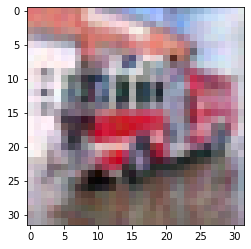

truck


In [142]:
# load our adversarial attack dataset for testing (label - for robust features)
ours_adversarial_test = torch.load('/content/drive/My Drive/Project_DL/AA.pt')
values = [torch.tensor(image[0]).float().reshape(3, 32, 32) for image in ours_adversarial_test]
labels = [image[1].item() for image in ours_adversarial_test]

ours_set_adversarial_test = Data_to_load(values, labels)
ours_loader_adversarial_test = torch.utils.data.DataLoader(ours_set_adversarial_test, batch_size=128, shuffle=False)

# printing images from datasets
print("Our adversarial dataset:")
imshow(torch.tensor(ours_set_adversarial_test[38][0]).detach().cpu())
print(classes[ours_set_adversarial_test[38][1]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Our ddet dataset:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


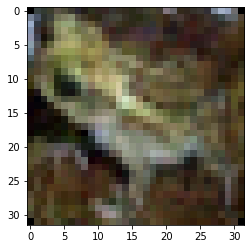

horse


In [144]:
# load our ddet dataset for testing (label - for non-robust features)
ours_ddet_test = torch.load('/content/drive/My Drive/Project_DL/DED.pt')
values = [torch.tensor(image[0]).float().reshape(3, 32, 32).cpu() for image in ours_ddet_test]
labels = [image[2].item() for image in ours_ddet_test]

ours_set_ddet_test = Data_to_load(values, labels, transform)
ours_loader_ddet_test = torch.utils.data.DataLoader(ours_set_ddet_test, batch_size=128, shuffle=False)

# printing images from datasets
print("Our ddet dataset:")
imshow(torch.tensor(ours_set_ddet_test[100][0]).detach().cpu())
print(classes[ours_set_ddet_test[100][1]])

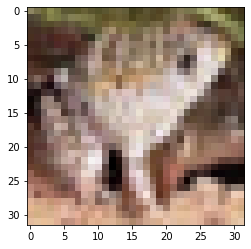

GroundTruth:      c a t


In [0]:
# loading data from the paper ddrand_CIFAR
data_path = "./drive/My Drive/Project_DL/drand_CIFAR"

data_drand = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_ims")))
labels_drand = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_lab")))
set_drand = Data_to_load(data_drand, labels_drand, transform)
loader_drand = torch.utils.data.DataLoader(set_drand, batch_size=128, shuffle=True)

# print image from their ddrand
imshow(data_drand[5])
print('GroundTruth: ', ' '.join('%5s' % classes[labels_drand[5]]))

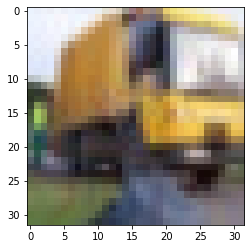

GroundTruth:  p l a n e


In [0]:
# loading data from the paper ddet_CIFAR
# no data augmentation for ddet_CIFAR
data_path = "./drive/My Drive/Project_DL/ddet_CIFAR"

data_ddet = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_ims")))
labels_ddet = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_lab")))
set_ddet = Data_to_load(data_ddet, labels_ddet, transform=None)
loader_ddet = torch.utils.data.DataLoader(set_ddet, batch_size=128, shuffle=True)

# print image from their ddet
imshow(data_ddet[5])
print('GroundTruth: ', ' '.join('%5s' % classes[labels_ddet[5]]))

## Evaluation of regular, robust, non-robust (ours and from the paper) of a regular trained classifier

In [91]:
# evaluate on standard net trained on CIFAR
# accuracy for robust, non-robust from the paper
net = make_model()
net.load_state_dict(torch.load('/content/drive/My Drive/Project_DL/regular_classif_dict.pth'))

accuracy_standard = model_eval(net, testloader)
accuracy_robust = model_eval(net, train_loader_robust)
accuracy_non_robust = model_eval(net, train_loader_non_robust)

print("Accuracy of our standard net on standard test:", accuracy_standard)

print("\n")

print("Accuracy of our standard net on their robust set :", accuracy_robust)
print("Accuracy of our standard net on their non-robust set:", accuracy_non_robust)

print("\n")
# accuracy for robust, non-robust ours
accuracy_robust = model_eval(net, ours_loader_robust_test)
accuracy_non_robust = model_eval(net, ours_loader_non_robust_test)

print("Accuracy of our standard net on our robust set :", accuracy_robust)
print("Accuracy of our standard net on our non-robust set:", accuracy_non_robust)

print("\n")

# accuracy for adversarials
accuracy_adv = model_eval(net, ours_loader_adversarial_test)

print("Accuracy of our standard net on adversarials :", accuracy_adv)


Accuracy of our standard net on standard test: 89.74


Accuracy of our standard net on their robust set : 78.118
Accuracy of our standard net on their non-robust set: 25.712


Accuracy of our standard net on our robust set : 83.74205267938238
Accuracy of our standard net on our non-robust set: 100.0


Accuracy of our standard net on adversarials : 0.199203187250996


## Experiment 1

#### Pretrained ResNet50 trained on robust and non-robust from the paper, evaluated on our adversarials

In [0]:
net, test_accuracy_robust, train_loss_robust, train_accuracy_robust = run(net, train_loader = train_loader_robust, 
        path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_robust.pth')

#Epoch: 0 | Loss Train: 0.504 | Acc train: 82.974 | Acc: 49.180
#Epoch: 1 | Loss Train: 0.480 | Acc train: 83.824 | Acc: 58.530
#Epoch: 2 | Loss Train: 0.481 | Acc train: 83.822 | Acc: 62.440
#Epoch: 3 | Loss Train: 0.481 | Acc train: 83.666 | Acc: 50.840
#Epoch: 4 | Loss Train: 0.479 | Acc train: 83.828 | Acc: 49.330
#Epoch: 5 | Loss Train: 0.474 | Acc train: 84.046 | Acc: 55.830
#Epoch: 6 | Loss Train: 0.467 | Acc train: 84.224 | Acc: 57.870
#Epoch: 7 | Loss Train: 0.471 | Acc train: 84.038 | Acc: 62.950
#Epoch: 8 | Loss Train: 0.467 | Acc train: 84.224 | Acc: 59.250
#Epoch: 9 | Loss Train: 0.468 | Acc train: 83.972 | Acc: 58.710
#Epoch: 10 | Loss Train: 0.470 | Acc train: 84.202 | Acc: 55.200
#Epoch: 11 | Loss Train: 0.467 | Acc train: 84.096 | Acc: 49.950
#Epoch: 12 | Loss Train: 0.466 | Acc train: 84.328 | Acc: 58.450
#Epoch: 13 | Loss Train: 0.458 | Acc train: 84.484 | Acc: 62.520
#Epoch: 14 | Loss Train: 0.460 | Acc train: 84.388 | Acc: 49.210
#Epoch: 15 | Loss Train: 0.464 | Ac

NameError: ignored

In [0]:
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])
net, test_accuracy_non_robust, train_loss_non_robust, train_accuracy_non_robust = run(net, 
                                              train_loader = train_loader_non_robust, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_non_robust.pth',
                                              n_epoch=25)

#Epoch: 0 | Loss Train: 2.096 | Acc train: 24.010 | Acc: 28.870
#Epoch: 1 | Loss Train: 1.701 | Acc train: 41.166 | Acc: 34.040
#Epoch: 2 | Loss Train: 1.489 | Acc train: 48.762 | Acc: 41.450
#Epoch: 3 | Loss Train: 1.371 | Acc train: 53.108 | Acc: 41.840
#Epoch: 4 | Loss Train: 1.291 | Acc train: 56.096 | Acc: 16.780
#Epoch: 5 | Loss Train: 1.207 | Acc train: 59.150 | Acc: 36.440
#Epoch: 6 | Loss Train: 1.172 | Acc train: 60.250 | Acc: 30.400
#Epoch: 7 | Loss Train: 1.120 | Acc train: 62.050 | Acc: 39.130
#Epoch: 8 | Loss Train: 1.092 | Acc train: 63.368 | Acc: 30.350
#Epoch: 9 | Loss Train: 1.069 | Acc train: 63.830 | Acc: 49.080
#Epoch: 10 | Loss Train: 1.055 | Acc train: 64.580 | Acc: 25.730
#Epoch: 11 | Loss Train: 1.036 | Acc train: 65.018 | Acc: 30.340
#Epoch: 12 | Loss Train: 1.002 | Acc train: 66.368 | Acc: 32.030
#Epoch: 13 | Loss Train: 0.999 | Acc train: 66.552 | Acc: 33.040
#Epoch: 14 | Loss Train: 0.985 | Acc train: 66.880 | Acc: 42.970
#Epoch: 15 | Loss Train: 0.969 | Ac

In [92]:
# evaluation of robust accuracy (on adversarial attack) and standard accuracy

# for robust net
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_robust.pth'))
accuracy_robust = model_eval(net, ours_loader_adversarial_test)
accuracy_robust_standard_test = model_eval(net, testloader)

# for non-robust net
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_non_robust.pth'))
accuracy_non_robust = model_eval(net, ours_loader_adversarial_test)
accuracy_non_robust_standard_test = model_eval(net, testloader)

print("Accuracy of robust net on our adversarial CIFAR:", accuracy_robust)
print("Accuracy of non-robust net on our adversarial CIFAR:", accuracy_non_robust)
print("Accuracy of robust net on standard test:", accuracy_robust_standard_test)
print("Accuracy of non-robust net on standard test:", accuracy_non_robust_standard_test)

Accuracy of robust net on our adversarial CIFAR: 60.55776892430279
Accuracy of non-robust net on our adversarial CIFAR: 33.764940239043824
Accuracy of robust net on standard test: 65.86
Accuracy of non-robust net on standard test: 49.08


#### Our net (vgg16) trained on our non-robust and robust, evaluated on our adversarials

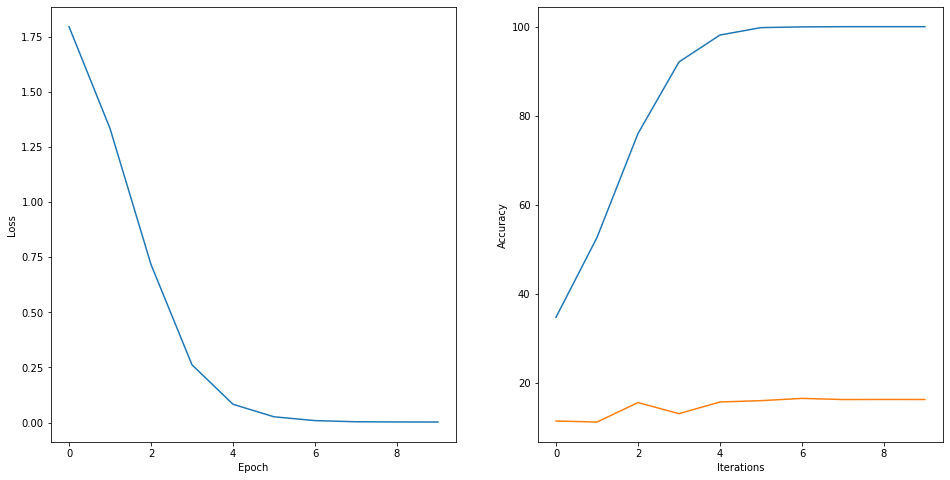

#Epoch: 9 | Loss Train: 0.002 | Acc train: 100.000 | Acc: 16.280


KeyboardInterrupt: ignored

In [118]:
# run training of our net on  our non_robust
net = make_model()
net, test_accuracy_our_non_robust, train_loss_our_non_robust, train_accuracy_our_non_robust = run(net, 
                                              train_loader = ours_loader_non_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_vgg16_our_non_robust.pth',
                                              n_epoch=25, lr=0.01, scheduled=True)


In [119]:
# load vgg16 trained on non-robust
# evaluate on our adversarials

net = make_model()
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_vgg16_our_non_robust.pth', map_location=device))

accuracy_non_robust = model_eval(net, ours_loader_adversarial_test)
accuracy_test = model_eval(net, testloader)

print("Accuracy of vgg16 trained on our non-robust evaluated on our adversarials:", accuracy_non_robust)
print("Accuracy of vgg16 trained on our non-robust evaluated on standard test:", accuracy_test)

Accuracy of vgg16 trained on our non-robust evaluated on our adversarials: 9.760956175298805
Accuracy of vgg16 trained on our non-robust evaluated on standard test: 16.28


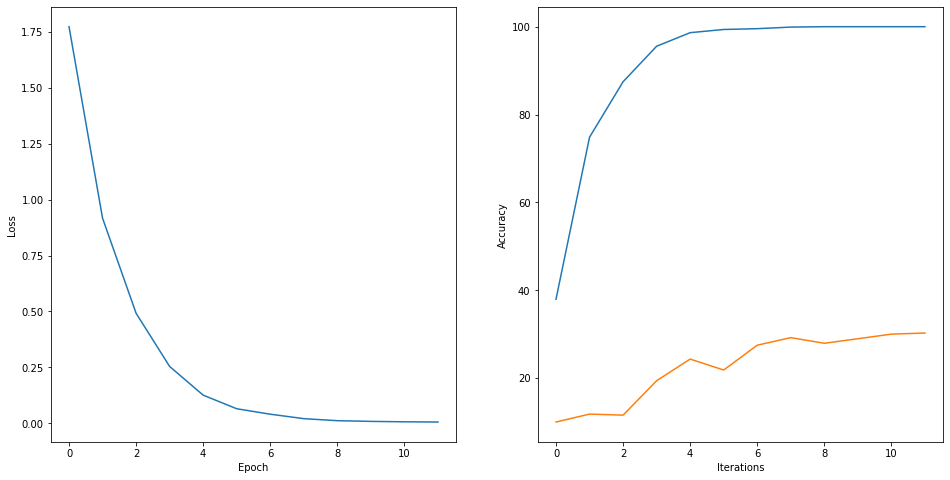

#Epoch: 11 | Loss Train: 0.006 | Acc train: 100.000 | Acc: 30.260

Finished Training


In [120]:
# run training of our net on  our non_robust
net = make_model()
net, test_accuracy_our_robust, train_loss_our_robust, train_accuracy_our_robust = run(net, 
                                              train_loader = ours_loader_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_vgg16_our_robust.pth',
                                              n_epoch=12, lr=0.01, scheduled=True)


In [121]:
# load vgg16 trained on robust
# evaluate on our adversarials

net = make_model()
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_vgg16_our_robust.pth', map_location=device))

accuracy_non_robust = model_eval(net, ours_loader_adversarial_test)
accuracy_test = model_eval(net, testloader)

print("Accuracy of vgg16 trained on our robust evaluated on our adversarials:", accuracy_non_robust)
print("Accuracy of vgg16 trained on our robust evaluated on standard test:", accuracy_test)

Accuracy of vgg16 trained on our robust evaluated on our adversarials: 28.58565737051793
Accuracy of vgg16 trained on our robust evaluated on standard test: 30.26


#### Pretrained ResNet50 on our non-robsut and robust dataset, evaluated on our adversarials

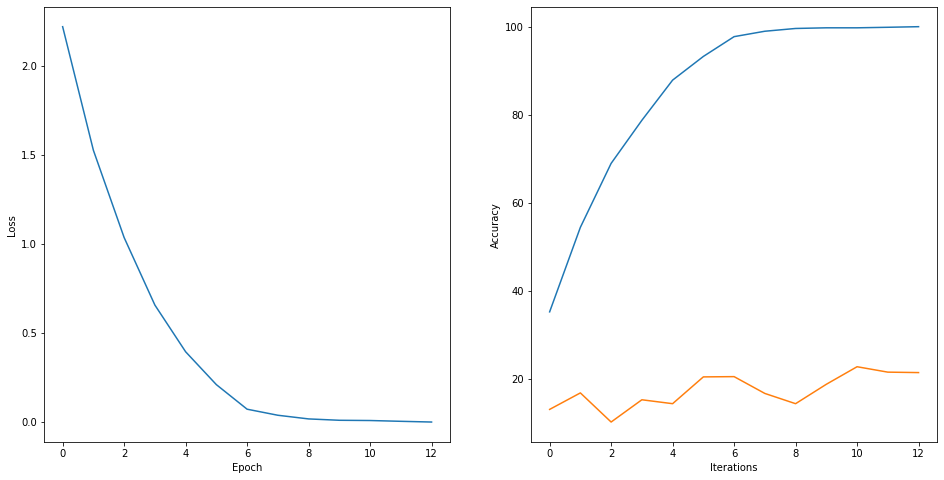

#Epoch: 12 | Loss Train: 0.001 | Acc train: 100.000 | Acc: 21.380


KeyboardInterrupt: ignored

In [122]:
# run training on our non-robust
net = []
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net, test_accuracy_non_rob, train_loss_non_rob, train_accuracy_non_rob = run(net, 
                                              train_loader = ours_loader_non_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_our_non_rob.pth',
                                              n_epoch=15, lr=0.01, scheduled=True)


In [123]:
# evaluate on standard test dataset and adversarials
# for net trained on our non-robust
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_our_non_rob.pth'))
accuracy_test = model_eval(net, testloader)
accuracy_adv = model_eval(net, ours_loader_adversarial_test)

print("Accuracy of pretrained resnet trained on our non-robust evaluated on standard test:", accuracy_test)
print("Accuracy of pretrained resnet trained on our non-robust evaluated on our adversarials:", accuracy_adv)

Accuracy of pretrained resnet trained on our non-robust evaluated on standard test: 21.38
Accuracy of pretrained resnet trained on our non-robust evaluated on our adversarials: 13.346613545816734


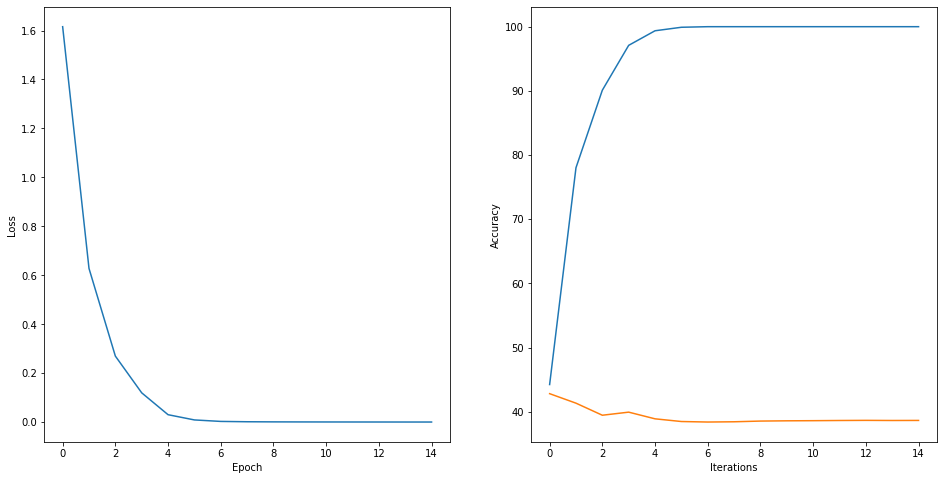

#Epoch: 14 | Loss Train: 0.001 | Acc train: 100.000 | Acc: 38.640

Finished Training


In [124]:
# run training on our robust
net = []
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net, test_accuracy_rob, train_loss_rob, train_accuracy_rob = run(net, 
                                              train_loader = ours_loader_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_our_rob.pth',
                                              n_epoch=15, lr=0.01, scheduled=True)


In [125]:
# evaluate on standard test dataset and adversarials
# for net trained on our robust
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_our_rob.pth'))
accuracy_test = model_eval(net, testloader)
accuracy_adv = model_eval(net, ours_loader_adversarial_test)

print("Accuracy of pretrained resnet trained on our robust evaluated on standard test:", accuracy_test)
print("Accuracy of pretrained resnet trained on our robust evaluated on our adversarials:", accuracy_adv)

Accuracy of pretrained resnet trained on our robust evaluated on standard test: 38.64
Accuracy of pretrained resnet trained on our robust evaluated on our adversarials: 31.97211155378486


#### Not pretrained ResNet50 on our non-robust and robust dataset, evaluated on our adversarials

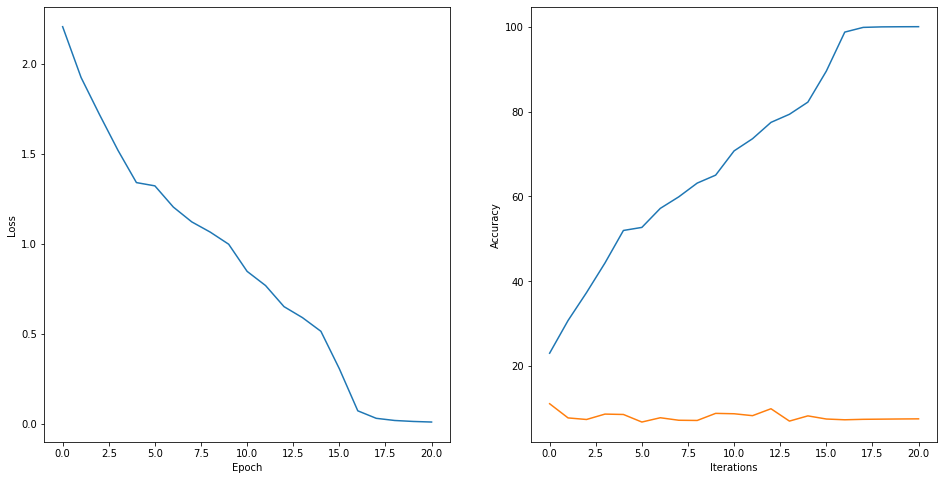

#Epoch: 20 | Loss Train: 0.011 | Acc train: 99.985 | Acc: 7.600


KeyboardInterrupt: ignored

In [126]:
# run training on our non rob
# the plots are such because it was not the first iteration
net = []
net = nn.ModuleList([resnet50_not_pretrained, nn.Linear(1000, 10)])

net, test_accuracy_non_rob, train_loss_non_rob, train_accuracy_non_rob = run(net, 
                                              train_loader = ours_loader_non_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_non_rob.pth',
                                              n_epoch=30, lr=0.01, scheduled=True)


In [127]:
# evaluate on standard test dataset + adversarials
# for not pretrained resnet50 trained on our non-robust

net = nn.ModuleList([resnet50_not_pretrained, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_non_rob.pth'))
accuracy_test = model_eval(net, testloader)
accuracy_adv = model_eval(net, ours_loader_adversarial_test)

print("Accuracy of not pretrained resnet trained on our non-robust evaluated on standard test:", accuracy_test)
print("Accuracy of not pretrained resnettrained on our non-robust evaluated on our adversarials:", accuracy_adv)

Accuracy of not pretrained resnet trained on our non-robust evaluated on standard test: 7.6
Accuracy of not pretrained resnettrained on our non-robust evaluated on our adversarials: 9.063745019920319


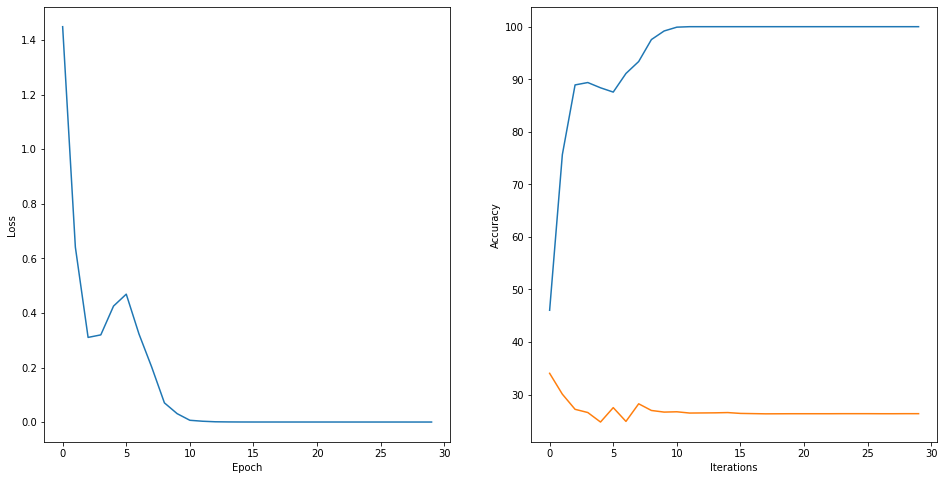

#Epoch: 29 | Loss Train: 0.000 | Acc train: 100.000 | Acc: 26.370

Finished Training


In [128]:
# run training on our rob
net = []
net = nn.ModuleList([resnet50_not_pretrained, nn.Linear(1000, 10)])

net, test_accuracy_non_rob, train_loss_non_rob, train_accuracy_non_rob = run(net, 
                                              train_loader = ours_loader_robust_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_rob.pth',
                                              n_epoch=30, lr=0.01, scheduled=True)


In [129]:
# evaluate on standard test dataset + adversarials
# for not pretrained resnet50 trained on our robust

net = nn.ModuleList([resnet50_not_pretrained, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_rob.pth'))
accuracy_test = model_eval(net, testloader)
accuracy_adv = model_eval(net, ours_loader_adversarial_test)

print("Accuracy of not pretrained resnet trained on our robust evaluated on standard test:", accuracy_test)
print("Accuracy of not pretrained resnettrained on our robust evaluated on our adversarials:", accuracy_adv)

Accuracy of not pretrained resnet trained on our non-robust evaluated on standard test: 26.37
Accuracy of not pretrained resnettrained on our non-robust evaluated on our adversarials: 26.693227091633467


## Experiment 2

#### Pretrained ResNet50 on the datasets from the paper

In [0]:
print("Length of their ddrand CIFAR and ddet CIFAR:", len(data_drand), len(data_ddet))

Length of their ddrand CIFAR and ddet CIFAR: 50000 50000


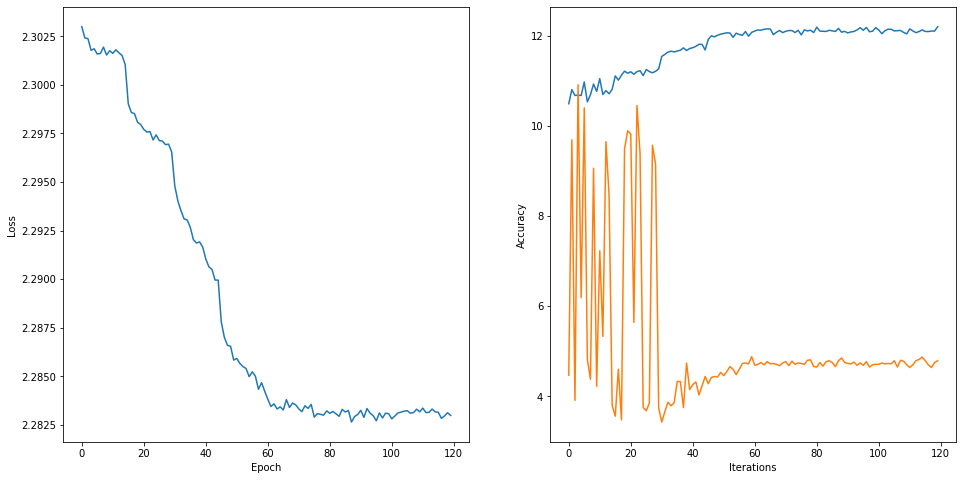

#Epoch: 119 | Loss Train: 2.283 | Acc train: 12.200 | Acc: 4.790

Finished Training


In [0]:
# run training on drand
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])
net, test_accuracy_drand, train_loss_drand, train_accuracy_drand = run(net, 
                                              train_loader = loader_drand, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_drand.pth',
                                              n_epoch=120, lr=0.1, scheduled=True)


In [0]:
# evaluate on standard test dataset
# for net trained on drand 
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_drand.pth'))
accuracy_drand = model_eval(net, testloader)

print("Accuracy of net trained on drand on standard test dset:", accuracy_drand)

Accuracy of net trained on drand on standard test dset: 10.81


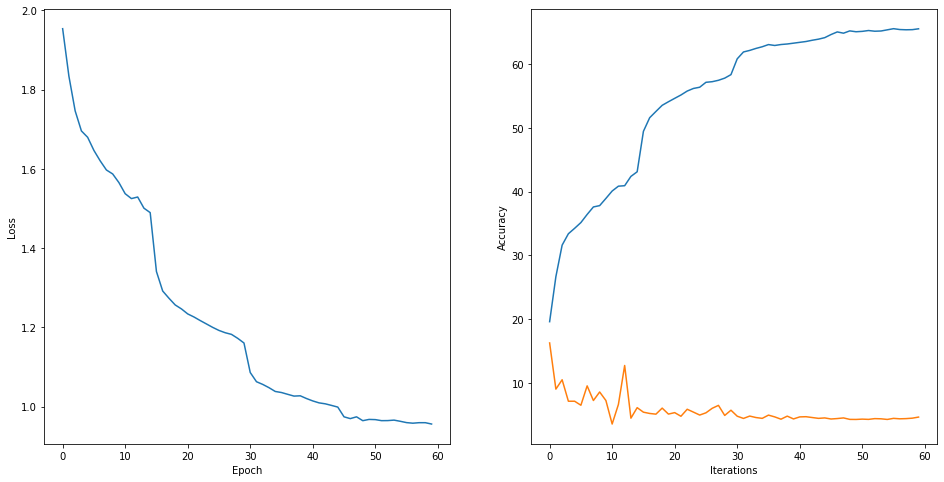

#Epoch: 59 | Loss Train: 0.956 | Acc train: 65.540 | Acc: 4.590

Finished Training


In [0]:
# run training on ddet
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net, test_accuracy_drand, train_loss_drand, train_accuracy_drand = run(net, 
                                              train_loader = loader_ddet, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_ddet.pth',
                                              n_epoch=60, lr=0.1, scheduled=True)


In [0]:
# evaluate on standard test dataset
# for net trained on drand 
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_ddet.pth'))
accuracy_ddet = model_eval(net, testloader)

print("Accuracy of net trained on ddet on standard test dset:", accuracy_ddet)

Accuracy of net trained on drand on standard test dset: 12.69


#### vgg16 on datasets from the paper

In [0]:
net = make_model()
#net.to(device)

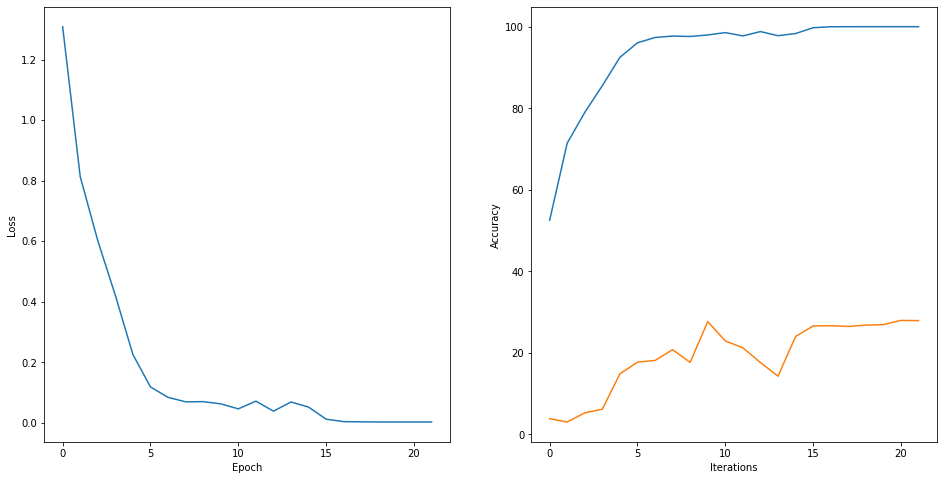

#Epoch: 21 | Loss Train: 0.002 | Acc train: 100.000 | Acc: 27.920


KeyboardInterrupt: ignored

In [0]:
# run training on ddet
net, test_accuracy_drand, train_loss_drand, train_accuracy_drand = run(net, 
                                              train_loader = loader_ddet, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_our_net_ddet.pth',
                                              n_epoch=60, lr=0.1, scheduled=True)


In [0]:
# evaluate on standard test dataset
# for our net trained on ddet 
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_our_net_ddet.pth'))
accuracy_ddet = model_eval(net, testloader)

print("Accuracy of net trained on drand on standard test dset:", accuracy_ddet)

Accuracy of net trained on drand on standard test dset: 27.92


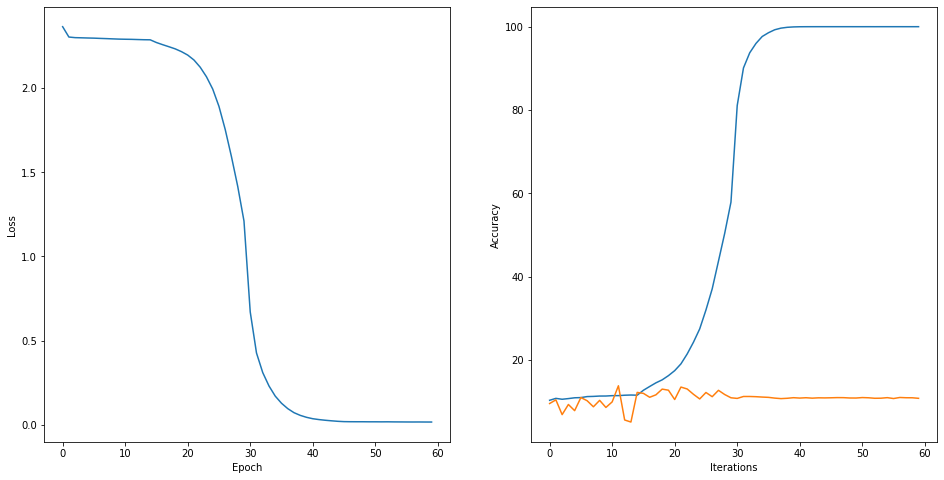

#Epoch: 59 | Loss Train: 0.016 | Acc train: 100.000 | Acc: 10.820

Finished Training


In [0]:
# run training on drand

net, test_accuracy_drand, train_loss_drand, train_accuracy_drand = run(net, 
                                              train_loader = loader_drand, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_our_net_drand.pth',
                                              n_epoch=60, lr=0.1, scheduled=True)


In [0]:
# evaluate on standard test dataset
# for our net trained on ddet 
net = make_model()
net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_our_net_drand.pth'))
accuracy_drand = model_eval(net, testloader)

print("Accuracy of net trained on drand on standard test dset:", accuracy_drand)

Accuracy of net trained on drand on standard test dset: 10.82


#### Pretrained Resnet50 on our ddet, evaluate on test

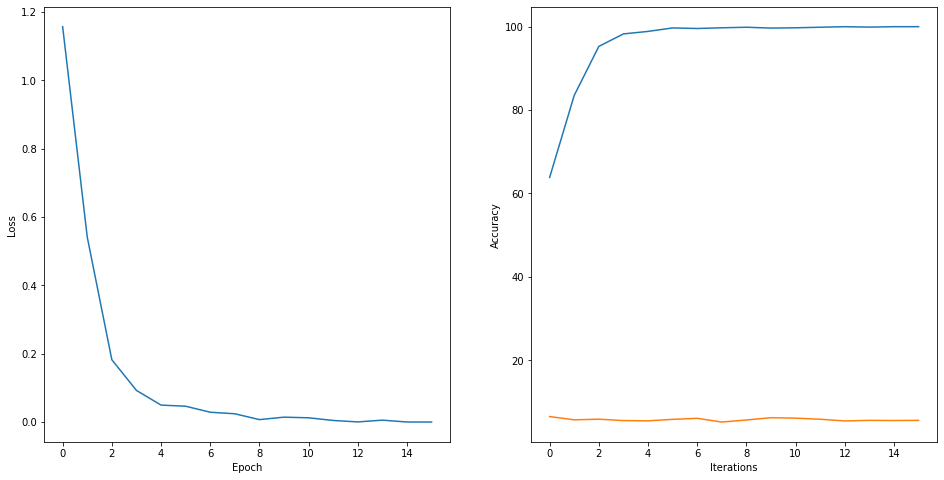

#Epoch: 15 | Loss Train: 0.000 | Acc train: 100.000 | Acc: 5.590

Finished Training


In [138]:
# run training on ddet
net = []
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])
net, test_accuracy_ddet, train_loss_ddet, train_accuracy_ddet = run(net, 
                                              train_loader = ours_loader_ddet_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_our_ddet.pth',
                                              n_epoch=16, lr=0.01, scheduled=True)


In [139]:
# evaluate on standard test dataset
# for net trained on our ddet 
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_our_ddet.pth'))
accuracy_ddet = model_eval(net, testloader)

print("Accuracy of net trained on ddet on standard test dset:", accuracy_ddet)

Accuracy of net trained on ddet on standard test dset: 5.59


#### Not pretrained Resnet50 on our ddet, evaluate on test

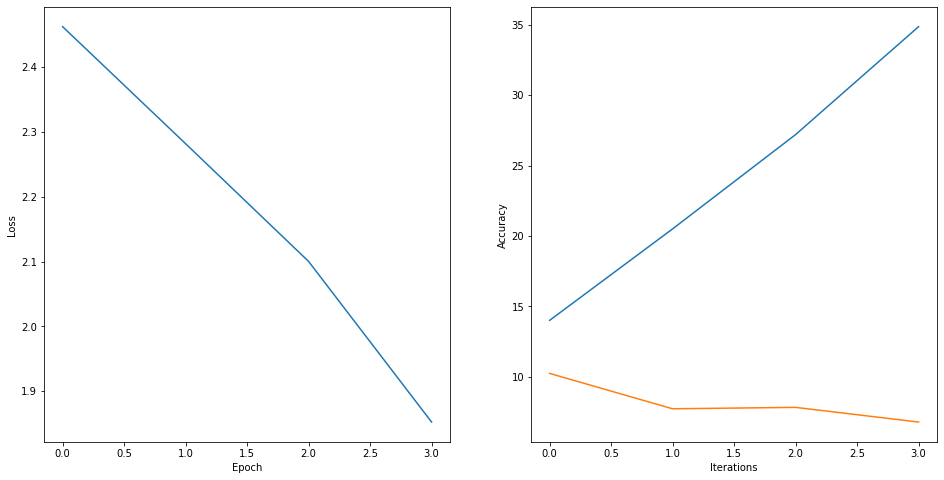

#Epoch: 3 | Loss Train: 1.852 | Acc train: 34.854 | Acc: 6.800


Process Process-586:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 134, in close
    self._reader.close()
Traceback (most recent call last):
Process Process-585:


KeyboardInterrupt: ignored

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 199, in _worker_loop
    data_queue.close()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 296, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, 

In [135]:
# run training on ddet
net = []
net = nn.ModuleList([resnet50_not_pretrained, nn.Linear(1000, 10)])

net, test_accuracy_ddet, train_loss_ddet, train_accuracy_ddet = run(net, 
                                              train_loader = ours_loader_ddet_test, 
                                              path_save_dict='./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_ddet.pth',
                                              n_epoch=20, lr=0.01, scheduled=True)


In [140]:
# evaluate on standard test dataset
# for net trained on our ddet 
net = []
net = nn.ModuleList([resnet50, nn.Linear(1000, 10)])

net.load_state_dict(torch.load('./drive/My Drive/Project_DL/checkpoint_resnet_50_not_pretrained_our_ddet.pth'))
accuracy_ddet = model_eval(net, testloader)

print("Accuracy of net trained on ddet on standard test dset:", accuracy_ddet)

Accuracy of net trained on ddet on standard test dset: 6.8
